### 비디오 처리

#### 필요한 라이브러리 임포트

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets 
import IPython.display as display
from ipywidgets import Layout, Button, Box, Layout, Image, IntSlider, AppLayout
import matplotlib.animation as animation

### 평균 배경 차영상
비디오에서 영상 분할은 배경(background)으로부터 전경(foreground)의 물체를 분할하는 것이 중요한 문제이다.  
배경 차영상(background subtraction)은 가장 간단한 비디오 영상 분할 방법이다.  
배경영상과 현재 입력 프레임 영상 사이의 화소 차이를 계산하고, 임계값 이상의 화소 위치를 변화가 있는 화소로 판단한다.  
<img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/OpenCV/120.PNG" height="100%" width="100%" />
<br>
사진 참조:<a href="https://vlgiitr.github.io/documentation/Computer_Vision/Foreground%20Extraction/">vlgiitr 블로그</a><br>

<code>cv2.accumulate(src, dst[, mask])</code>: 화소 누적 합  
<p>$$dst(x,y) \leftarrow dst(x,y) + src(x,y) \text{ if  } mask(x,y) \neq 0$$</p>

**parameter**
- src: input image
- dst: output image
- mask: Optional operation mask

<br>

<code>cv2.accumulateSquare(src, dst[, mask])</code>: 화소 제곱 합  
<p>$$dst(x,y) \leftarrow dst(x,y) + src(x,y)^2 \text{ if  } mask(x,y) \neq 0$$</p>

<br>

<code>cv2.accumulateProduct(src1, src2, dst[, mask])</code>: 화소2개의 product 후 누적 합  
<p>$$dst(x,y) \leftarrow dst(x,y) + src1(x,y)\cdot src2(x,y) \text{ if  } mask(x,y) \neq 0$$</p>

**parameter**
- src1: input image1
- src2: input image2
- dst: output image
- mask: Optional operation mask

<br>

<code>cv2.accumulateWeighted(src, dst, alpha[, mask])</code>: 가중치를 적용한 화소 누적 합  
<p>$$dst(x,y) \leftarrow (1-\alpha) \cdot dst(x,y) + \alpha \cdot src(x,y) \text{ if  } mask(x,y) \neq 0$$</p>

**parameter**
- src: input image
- dst: output image
- alpha: weight
- mask: Optional operation mask

<br>

#### 평균에 의한 배경영상
동영상 재생시 매 frame을 더한 뒤 frame의 수로 나눈다.  
이동하는 물체는 지속적으로 움직여 frame에서 사라지거나 값이 계속 바뀌므로 결국 **움직이지 않는 background만 남게 될 것 이다.**  

- avg_gray: 매 frame을 gray로 변환후 더한 뒤 frame의 수로 나눈다.
- avg_bgr: 매 frame을 더한 뒤 frame의 수로 나눈다.

**참고사항**  
<code>cv2.convertScaleAbs(src[, dst[, alpha[, beta]]])</code>: 절대값 계산후 8bit로서 표현  
<p>$$dst(I) = saturate-cast<unchar(8bit)>(|src(I)*alpha+beta|)$$</p>

**parameter**
- src: input array
- dst: output array
- alpha: optional scale facotr
- mask: optional delta added to the scaled values

<br>

In [ ]:
cap = cv2.VideoCapture('./data/vtest.avi')
if(not cap.isOpened()):
    print('Error opening video')

height,width = (int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))

acc_gray = np.zeros(shape=(height,width),dtype=np.float32)
acc_bgr = np.zeros(shape=(height,width,3),dtype=np.float32)
t=0

wImg1 = widgets.Image(layout = widgets.Layout(border="solid"), width="30%") 
wImg2 = widgets.Image(layout = widgets.Layout(border="solid"), width="30%") 
wImg3 = widgets.Image(layout = widgets.Layout(border="solid"), width="30%") 

items = [wImg1, wImg2, wImg3]
box = Box(children=items)

display.display(box)

while True:
    try:
        retval, frame = cap.read()
        if not retval:
            break
        t+=1
        gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        
        cv2.accumulate(gray,acc_gray)
        avg_gray = acc_gray/t
        dst_gray = cv2.convertScaleAbs(avg_gray)
        
        cv2.accumulate(frame,acc_bgr)
        avg_bgr = acc_bgr/t
        dst_bgr = cv2.convertScaleAbs(avg_bgr)
        
        wImg1.value = cv2.imencode(".jpeg", frame)[1].tostring()
        wImg2.value = cv2.imencode(".jpeg", dst_gray)[1].tostring()
        wImg3.value = cv2.imencode(".jpeg", dst_bgr)[1].tostring()
    
    except KeyboardInterrupt:
        break
        
if cap.isOpened():
    cap.release()

cv2.imwrite('./data/avg_gray.png',dst_gray)
cv2.imwrite('./data/avg_bgr.png',dst_bgr)

#### 배경 차영상 이동물체 검출
위에서 추출한 각각의 배경영상 "avg_gray.png, avg_bgr.png"를 통하여 영상과 배경 image의 차이(<code>cv2.absdiff()</code>)로서 이동하는 물체를 검출한다.  
Image 이동물체 검출은 다음과 같은 순서로 진행된다.  
1. Frame과 Background의 Image의 차이 계산
2. 특정 Threshold 이상의 값을 추출
3. Color Image의 경우 RGB로서 Split
4. 각각의 분할된 Image의 bitwise_or을 통하여 BImage 생성
5. BImage를 반복적인 Erode와 Dilate로 인하여 Noise제거 (<a href="https://wjddyd66.github.io/opencv/2019/10/29/OpenCV(5).html">erode, dilage 자세한 내용</a>)
6. <code>cv2.drawContontours()</code>를 통하여 윤곽선 검출
7. <code>cv2.contourArea()</code>를 통하여 Moving Object의 크기 추출후 특정 크기 이상의 물체만 검출


In [ ]:
cap = cv2.VideoCapture('./data/vtest.avi')
if(not cap.isOpened()):
    print('Error opening video')

height,width = (int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
t=0
TH = 40 #Binary Threshold
AREA_TH = 80 #Area Threshold
bkg_gray = cv2.imread('./data/avg_gray.png',cv2.IMREAD_GRAYSCALE)
bkg_bgr = cv2.imread('./data/avg_bgr.png')

mode = cv2.RETR_EXTERNAL
method = cv2.CHAIN_APPROX_SIMPLE

wImg1 = widgets.Image(layout = widgets.Layout(border="solid"), width="20%") 
wImg2 = widgets.Image(layout = widgets.Layout(border="solid"), width="20%") 
wImg3 = widgets.Image(layout = widgets.Layout(border="solid"), width="20%") 
wImg4 = widgets.Image(layout = widgets.Layout(border="solid"), width="20%")

items = [wImg1, wImg2, wImg3, wImg4]
box = Box(children=items)

display.display(box)

while True:
    try:
        retval, frame = cap.read()
        if not retval:
            break
        t+=1
        gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        
        diff_gray = cv2.absdiff(gray,bkg_gray)
        diff_bgr = cv2.absdiff(frame,bkg_bgr)
        
        db,dg,dr = cv2.split(diff_bgr)
        ret,bb = cv2.threshold(db,TH,255,cv2.THRESH_BINARY)
        ret,bg = cv2.threshold(dg,TH,255,cv2.THRESH_BINARY)
        ret,br = cv2.threshold(dr,TH,255,cv2.THRESH_BINARY)
        
        bImage = cv2.bitwise_or(bb,bg)
        bImage = cv2.bitwise_or(br,bImage)
        bImage = cv2.erode(bImage,None,5)
        bImage = cv2.dilate(bImage,None,5)
        bImage = cv2.erode(bImage,None,7)
        
        image,contours,hierarchy = cv2.findContours(bImage,mode,method)
        cv2.drawContours(frame,contours,-1,(255,0,0),1)
        
        for i,cnt in enumerate(contours):
            area = cv2.contourArea(cnt)
            if area>AREA_TH:
                x,y,width,height = cv2.boundingRect(cnt)
                cv2.rectangle(frame,(x,y),(x+width,y+height),(0,0,255),2)
        
        wImg1.value = cv2.imencode(".jpeg", frame)[1].tostring()
        wImg2.value = cv2.imencode(".jpeg", bImage)[1].tostring()
        wImg3.value = cv2.imencode(".jpeg", diff_gray)[1].tostring()
        wImg4.value = cv2.imencode(".jpeg", diff_bgr)[1].tostring()
    
    except KeyboardInterrupt:
        break
        
if cap.isOpened():
    cap.release()

#### 이동평균 배경 차영상
위에서 결과 확인한 배경차영상 이동물체 검출과 거의 비슷하여 차이가 있는 곳을 확인하자.  
먼저 전부 동일하나 msk를 생성한다.  
msk는 이동물체 영역은 255, 배경은0으로서 판단한다.  
cv2.bitwise_not()을 통하여 msk를 이동물체 영역은 0, 배경은 255로서 판단한다.  
<code>cv2.accumulateWeighted(blur,bkg_bgr,alpha=0.1,mask=msk)</code>의 식은 다음과 같다.  
<p>$$dst(x,y) \leftarrow (0.9) \cdot bkgbgr(x,y) + 0.1 \cdot blur(x,y) \text{ if  } mask(x,y) \neq 0$$</p>

**Mask는 배경이 255인 곳만을 가르키고 있으므로 위에서 dst는 배경에만 영향을 받아서 계속되어 Update가 된다는 것을 알 수 있다.**  
또한, 하나의 Background만 사용하지 않고 가중치를 통하여 조정하긴 하였지만, 계속해서 움직이는 물체에 대한 Background가 Update가 된다.  
이러한 Algorithm의 장점으로 생각할 수 있는 것은, **현재 영상에서 추가로 다른 Object(EX) 가로등, 신호등)가 설치가 되어도 지속적인 움직임이 없으면 Background로 포함시킬 수 있다는 것 이다.**

In [ ]:
cap = cv2.VideoCapture('./data/vtest.avi')
if(not cap.isOpened()):
    print('Error opening video')

height,width = (int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
t=0
TH = 40 #Binary Threshold
AREA_TH = 80 #Area Threshold
acc_bgr = np.zeros(shape=(height,width,3),dtype=np.float32)

mode = cv2.RETR_EXTERNAL
method = cv2.CHAIN_APPROX_SIMPLE

wImg1 = widgets.Image(layout = widgets.Layout(border="solid"), width="20%") 
wImg2 = widgets.Image(layout = widgets.Layout(border="solid"), width="20%") 
wImg3 = widgets.Image(layout = widgets.Layout(border="solid"), width="20%") 
wImg4 = widgets.Image(layout = widgets.Layout(border="solid"), width="20%")

items = [wImg1, wImg2, wImg3, wImg4]
box = Box(children=items)

display.display(box)

while True:
    try:
        retval, frame = cap.read()
        if not retval:
            break
        t+=1
        blur = cv2.GaussianBlur(frame,(5,5),0.0)
        
        if t<50:
            cv2.accumulate(blur,acc_bgr)
            continue
        elif t ==50:
            bkg_bgr = acc_bgr/t
        
        diff_bgr = cv2.absdiff(np.float32(blur),bkg_bgr).astype(np.uint8)
        db,dg,dr = cv2.split(diff_bgr)
        
        ret,bb = cv2.threshold(db,TH,255,cv2.THRESH_BINARY)
        ret,bg = cv2.threshold(dg,TH,255,cv2.THRESH_BINARY)
        ret,br = cv2.threshold(dr,TH,255,cv2.THRESH_BINARY)
        
        bImage = cv2.bitwise_or(bb,bg)
        bImage = cv2.bitwise_or(br,bImage)
        bImage = cv2.erode(bImage,None,5)
        bImage = cv2.dilate(bImage,None,5)
        bImage = cv2.erode(bImage,None,7)
        
        msk = bImage.copy()
        
        image,contours,hierarchy = cv2.findContours(bImage,mode,method)
        cv2.drawContours(frame,contours,-1,(255,0,0),1)
        
        for i,cnt in enumerate(contours):
            area = cv2.contourArea(cnt)
            if area>AREA_TH:
                x,y,width,height = cv2.boundingRect(cnt)
                cv2.rectangle(frame,(x,y),(x+width,y+height),(0,0,255),2)
                cv2.rectangle(msk,(x,y),(x+width,y+height),255,-1)
        msk = cv2.bitwise_not(msk)
        cv2.accumulateWeighted(blur,bkg_bgr,alpha=0.1,mask=msk)
        
        wImg1.value = cv2.imencode(".jpeg", frame)[1].tostring()
        wImg2.value = cv2.imencode(".jpeg", bImage)[1].tostring()
        wImg3.value = cv2.imencode(".jpeg", np.uint8(bkg_bgr))[1].tostring()
        wImg4.value = cv2.imencode(".jpeg", diff_bgr)[1].tostring()
    
    except KeyboardInterrupt:
        break
        
if cap.isOpened():
    cap.release()

### BackgroundSubtractor로 배경과 전경 분할
전체적인 BS(BackgroundSubtractor)는 다음과 같은 Structure로서 구성되어 있다.  
<img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/OpenCV/121.PNG" height="100%" width="100%" /><br>

<code>cv2.BackgroundSubtractor.apply(image,fgmask,learningRate)</code>: image를 모델에 적용하여 8비트 전경마스크 fgmask를 계산한다.<br>

**parameter**
- image:Next video frame
- fgmask: foreground mask as an 8-bit binary image(Current Frame - Background model)
- leaningRate: 0 ~ 1 값으로 Background Model갱신을 어느정도 비율로 할지 정한다.
 - 0: BackGround Model을 갱신하지 않는다.
 - 1: BackGround Model을 마지막 프레임으로 갱신한다.
 
<br>

<code>cv2.BackgroundSubtractor.getBackgroundImage(backgroundImage)</code>: Background Image 반환<br>

<code>cv2.creteBackgroundSubtractorMoG(history, varThreshold, detectShadows)</code>: Gaussian Mixture-based Background/Foreground Segmentation Algorithm을 사용하여 Background와 Object를 분리한다.  
읽어보지는 않았지만 논문 <a href="http://personal.ee.surrey.ac.uk/Personal/R.Bowden/publications/avbs01/avbs01.pdf">An improved adaptive background mixture model for real-time tracking with shadow detection” by P. KadewTraKuPong and R. Bowden in 2001</a>의 원리로서 작동한다고 한다.<br>

**parameter**
- history: Background Model 검출에 영향을 주는 최근 프레임의 길이
- varThreshold: 배경을 판단하기 위한 Mahalanobis 거리 제곱의 임계치(작은 값을 사용하면 많은 화소를 전경(foreground)로 검출한다.)
- detectShadows: 그림자 검출 여부
 - True: 검출 O
 - False: 검출 X
 
<br>

<code>cv2.creteBackgroundSubtractorKNN(history, varThreshold, detectShadows)</code>: Creates KNN Background Subtractor 생성<br>


In [ ]:
cap = cv2.VideoCapture('./data/vtest.avi')
if(not cap.isOpened()):
    print('Error opening video')

height,width = (int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
t=0
AREA_TH = 80 #Area Threshold
bgMog1 = cv2.createBackgroundSubtractorMOG2()
bgMog2 = cv2.createBackgroundSubtractorMOG2(varThreshold=25, detectShadows=False)
bgMog3 = cv2.createBackgroundSubtractorKNN()
bgMog4 = cv2.createBackgroundSubtractorKNN(dist2Threshold=1000,detectShadows=False)

wImg1 = widgets.Image(layout = widgets.Layout(border="solid"), width="40%") 
wImg2 = widgets.Image(layout = widgets.Layout(border="solid"), width="40%") 
wImg3 = widgets.Image(layout = widgets.Layout(border="solid"), width="40%") 
wImg4 = widgets.Image(layout = widgets.Layout(border="solid"), width="40%")
wImg5 = widgets.Image(layout = widgets.Layout(border="solid"), width="40%") 
wImg6 = widgets.Image(layout = widgets.Layout(border="solid"), width="40%") 
wImg7 = widgets.Image(layout = widgets.Layout(border="solid"), width="40%") 
wImg8 = widgets.Image(layout = widgets.Layout(border="solid"), width="40%")

items = [wImg1, wImg2]
box1 = Box(children=items)
items = [wImg3, wImg4]
box2 = Box(children=items)
items = [wImg5, wImg6]
box3 = Box(children=items)
items = [wImg7, wImg8]
box4 = Box(children=items)

display.display(box1)
display.display(box2)
display.display(box3)
display.display(box4)

def findObjectAndDraw(bImage,src):
    res = src.copy()
    bImage = cv2.erode(bImage,None,5)
    bImage = cv2.dilate(bImage,None,5)
    bImage = cv2.erode(bImage,None,7)
    image,contours,hierarchy = cv2.findContours(bImage,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(frame,contours,-1,(255,0,0),1)
    for i,cnt in enumerate(contours):
        area = cv2.contourArea(cnt)
        if area>AREA_TH:
            x,y,width,height = cv2.boundingRect(cnt)
            cv2.rectangle(res,(x,y),(x+width,y+height),(0,0,255),2)
    return res

while True:
    try:
        retval, frame = cap.read()
        if not retval:
            break
        t+=1
        gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(frame,(5,5),0.0)
        
        bImage1 = bgMog1.apply(blur)
        bImage2 = bgMog2.apply(blur)
        bImage3 = bgMog3.apply(blur)
        bImage4 = bgMog4.apply(blur)
        dst1 = findObjectAndDraw(bImage1,frame)
        dst2 = findObjectAndDraw(bImage2,frame)
        dst3 = findObjectAndDraw(bImage3,frame)
        dst4 = findObjectAndDraw(bImage4,frame)
        
        
        wImg1.value = cv2.imencode(".jpeg", bImage1)[1].tostring()
        wImg2.value = cv2.imencode(".jpeg", dst1)[1].tostring()
        wImg3.value = cv2.imencode(".jpeg", bImage2)[1].tostring()
        wImg4.value = cv2.imencode(".jpeg", dst2)[1].tostring()
        wImg5.value = cv2.imencode(".jpeg", bImage3)[1].tostring()
        wImg6.value = cv2.imencode(".jpeg", dst3)[1].tostring()
        wImg7.value = cv2.imencode(".jpeg", bImage4)[1].tostring()
        wImg8.value = cv2.imencode(".jpeg", dst4)[1].tostring()
        
    
    except KeyboardInterrupt:
        break
        
if cap.isOpened():
    cap.release()

### 광류 계산
광류(optical flow)는 영상 화소 밝기의 움직임(motion)을 벡터로 계산하는 방법이다.  
광류는 두 영상 프레임(prenv, curr)의 각 화소에서 밝기의 속도벡터로 계산한다. 즉, 광류는 각 축 방향으로의 이동 벡터이며, 바늘도표로 표시한다.  
두 프레임간의 차이를 보여주는 2차원 변위 벡터(Displacement Vector)는 아래와 같다.  
<img src="http://www.gisdeveloper.co.kr/wp-content/uploads/2019/05/optical_flow_basic1.jpg"><br>
사진 출처: <a href="http://www.gisdeveloper.co.kr/?p=6855">gisdeveloper 블로그</a><br>

<code>cv2.calcOpticalFlowPyrLK(prevImg, nextImg, prevPts[, nextPts[, status[, err[, winSize[, maxLevel[, criteria[, flags[, minEigThreshold]]]]]]]])</code>: Lucas-Kanade method with pyramids를 통하여 optical flow 를 계산한다.<br>
**parameter**
- prevImg: first 8-bit input image or pyramid constructed by buildOpticalFlowPyramid().
- nextImg: second input image or pyramid of the same size and the same type as prevImg.
- prevPts: vector of 2D points for which the flow needs to be found; point -coordinates must be single-precision floating-point numbers.
- nextPts: output vector of 2D points

**parameter에 관해서는 너무 많으므로 링크 참조**
<a href="https://docs.opencv.org/2.4/modules/video/doc/motion_analysis_and_object_tracking.html">OpenCV 정식 홈페이지</a><br>

장점: **calcOpticalFlowPyrLK의 장점은 다양한 스케일의 이미지를 탐색하기 때문에 커다란 움직임도 찾아낼 수 있다는 장점이 있다.(pixel의 위치 변화가 큰 곳도 스케일을 변형시켜 탐지 할 수 있기 때문이다.)**  
단점: Dense optical flow가 아니다. 즉, 모든 KeyPoints에 대해서 계산하는 것이 아닌 몇몇 KeyPoints를 찾아서 계산하는 것 이므로 정확성이 떨어진다는 단점이 생긴다.  

<code>cv2.calcOpticalFlowFarneback(prev, next, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags[, flow])</code>: Gunnar Franeback's Algorithm을 통하여 optical flow 를 계산한다.<br>
**parameter**
- prev: first 8-bit single-channel input image.
- next: second input image of the same size and the same type as prev.
- flow: computed flow image that has the same size as prev and type CV_32FC2.
- pyr_scale: parameter, specifying the image scale (<1) to build pyramids for each image; pyr_scale=0.5 means a classical pyramid, where each next layer is twice smaller than the previous one.

**parameter에 관해서는 너무 많으므로 링크 참조**
<a href="https://docs.opencv.org/2.4/modules/video/doc/motion_analysis_and_object_tracking.html">OpenCV 정식 홈페이지</a><br>

장점: **<code>cv2.calcOpticalFlowPyrLK()</code>와 달리 dense optical flow이므로 모든 Pixel에 대한 KeyPoints를 통하여 계산하므로 정확도가 높다.**  
단점: 모든 KeyPoints에 대해서 계산하므로 계산시간이 오래 걸린다.    
내용 참조: <a href="https://eehoeskrap.tistory.com/124">꾸준히 블로그</a><br>
코드 출처: <a href="http://www.gisdeveloper.co.kr/?p=6855">gisdeveloper 블로그</a>

#### calcOpticalFlowPyrLK
- p0: <code>cv2.goodFeaturesToTrack()</code>을 이용하여 Parameter에 해당하는 Corner점 추출
- p1: <code>calcOpticalFlowPyrLK()</code>을 이용하여 광류 계산을 한다.
- frame: p0를 frame에 표시
- mask: p1과 p0를 line으로서 표시
- img: frame + mask를 통하여 Keypoints의 이동경로를 표시


In [ ]:
cap = cv2.VideoCapture('./data/vtest.avi')
 
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.01,
                       minDistance = 30,
                       blockSize = 14)
 
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 0,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
 
# Create some random colors
color = np.random.randint(0,255,(100,3))
 
# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
 
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)
 
wImg1 = widgets.Image(layout = widgets.Layout(border="solid"), width="40%") 
wImg2 = widgets.Image(layout = widgets.Layout(border="solid"), width="40%") 

items = [wImg1, wImg2]
box = Box(children=items)
display.display(box)

while(True):
    try:
        ret,frame = cap.read()
 
        if not ret:
            break
 
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
 
        # calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
 
        # Select good points
        good_new = p1[st==1]
        good_old = p0[st==1]
 
        # draw the tracks
        for i,(new,old) in enumerate(zip(good_new,good_old)):
            a,b = new.ravel()
            c,d = old.ravel()
            mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
            frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
        img = cv2.add(frame,mask)
         
        wImg1.value = cv2.imencode(".jpeg", frame)[1].tostring()
        wImg2.value = cv2.imencode(".jpeg", img)[1].tostring()
        
 
        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1,1,2)
 
    except KeyboardInterrupt:
        break
        
if cap.isOpened():
    cap.release()

#### calcOpticalFlowFarneback
- imgC: GrayScale로 변한 후 GaussianBlur 적용
- flow: <code>cv2.calcOpticalFlowFarneback()</code>로 광류 계산
- drawFlow: 입력받은 flow로서 일정 thresh보다 큰 magnitude를 dx,dy 방향으로 line 그리기
- bImage: 광류 크기를 Image로서 표현
- <code>cv2.contourArea()</code>를 통하여 일정 크기 이상의 Object Detection

**참고사항**  
<code>cv2.cartToPolar(x, y[, magnitude[, angle[, angleInDegrees]]])</code>: Calculates the magnitude and angle of 2D vector<br>

**parameter**
- x: array of x cordinates
- y: array of y-coordinates
- magnitude: output array of magnitudes of the same size and type as x.
- angle: output array of angles that has the same size and type as x; the angles are measured in radians (from 0 to 2*Pi) or in degrees (0 to 360 degrees).
- angleInDegrees – a flag, indicating whether the angles are measured in radians (which is by default), or in degrees.
- angle_in_degrees – a flag, indicating whether the angles are measured in radians, or in degrees (specific to C syntax).

<p>$$magnitude(I) = \sqrt{x(I)^2+y(I)^2}$$</p>
<p>$$angle(I) = atan2(y(I),x(I))[180/\pi]$$</p>

In [ ]:
def drawFlow(img,flow,thresh=2,stride=8):
    h,w = img.shape[:2]
    mag,ang = cv2.cartToPolar(flow[...,0],flow[...,1])
    flow2 = np.int32(flow)
    for y in range(0,h,stride):
        for x in range(0,w,stride):
            dx,dy = flow2[y,x]
            if mag[y,x]>thresh:
                cv2.circle(img,(x,y),2,(0,255,0),-1)
                cv2.line(img,(x,y),(x+dx,y+dy),(255,0,0),1)
                
cap = cv2.VideoCapture('./data/vtest.avi')
if(not cap.isOpened()):
    print('Error opening video')

height,width = (int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
t=0
hsv = np.zeros((height,width,3),dtype=np.uint8)
ret,frame = cap.read()
imgP = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

TH=2
AREA_TH=50
mode = cv2.RETR_EXTERNAL
method = cv2.CHAIN_APPROX_SIMPLE
params = dict(pyr_scale=0.5,levels=3,winsize=15,iterations=3,poly_n=5,poly_sigma=1.2,flags=0)

wImg = widgets.Image(layout = widgets.Layout(border="solid"), width="50%") 
display.display(wImg)

while True:
    try:
        retval, frame = cap.read()
        if not retval:
            break
        t+=1
        imgC = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        imgC = cv2.GaussianBlur(imgC,(5,5),0.5)
        
        flow = cv2.calcOpticalFlowFarneback(imgP,imgC,None,**params)
        drawFlow(frame,flow,TH)
        
        mag,ang = cv2.cartToPolar(flow[...,0],flow[...,1])
        ret,bImage = cv2.threshold(mag,TH,255,cv2.THRESH_BINARY)
        bImage = bImage.astype(np.uint8)
        image,contours,hierarchy = cv2.findContours(bImage,mode,method)
        for i,cnt in enumerate(contours):
            area = cv2.contourArea(cnt)
            if area > AREA_TH:
                x,y,width,height = cv2.boundingRect(cnt)
                cv2.rectangle(frame,(x,y),(x+width,y+height),(0,0,255),2)
                
        wImg.value = cv2.imencode(".jpeg", frame)[1].tostring()
        imgP = imgC.copy()
        
    except KeyboardInterrupt:
        break
        
if cap.isOpened():
    cap.release()

### MeanShift/CamShift 추적
meanShift와 CamShift는 물체의 히스토그램 역투영(histogram backprojection)을 이용하여 이동물체를 Tracking한다.  
**히스토그램 역투영**이란 물체의 모양은 무시하고 단순히 컬러 분포만으로 검출하는 방법으로, 히스토그램은 컬러 분포를 표현하는데 사용한다.  
아래 MeanShift/ComShift는 **Hue-채널의 히스토그램 역투영**으로서 이루워졌다.  

<code>cv2.meanShift(probImage, window, criteria)</code>: Back projection image를 통하여 Object 검출<br>

**parameter**
- probImage: Back projection of the object histogram
- window: Initial search window
- criteria: 탐색 종료 조건

<br>

<code>cv2.CamShift(probImage, window, criteria)</code>: Back projection image를 통하여 Object 검출<br>

#### ROI 선택 Method
자세한 내용:<a href="https://wjddyd66.github.io/opencv/2019/10/23/OpenCV(3).html">OpenCV-기본연산</a><br>

In [2]:
class bbox_select():
    %matplotlib notebook
    def __init__(self,im):
        self.im = im
        self.selected_points = []
        self.fig,ax = plt.subplots()
        self.img = ax.imshow(self.im.copy())
        self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        disconnect_button = widgets.Button(description="Disconnect mpl")
        display.display(disconnect_button)
        disconnect_button.on_click(self.disconnect_mpl)
        
        
    def poly_img(self,img,pts):
        pts = np.array(pts, np.int32)
        pt1 = pts[0,0],pts[0,1]
        pt2 = pts[1,0],pts[1,1]
        
        cv2.rectangle(img,pt1,pt2,(np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255)),7)
        return img

    def onclick(self, event):
        self.selected_points.append([event.xdata,event.ydata])
        
        if len(self.selected_points) == 2:
            self.fig
            self.img.set_data(self.poly_img(self.im.copy(),self.selected_points))
        
        elif len(self.selected_points) == 3:
            self.selected_points=[]
            self.selected_points.append([event.xdata,event.ydata])
                
            
    def disconnect_mpl(self,_):
        self.fig.canvas.mpl_disconnect(self.ka)

<IPython.core.display.Javascript object>


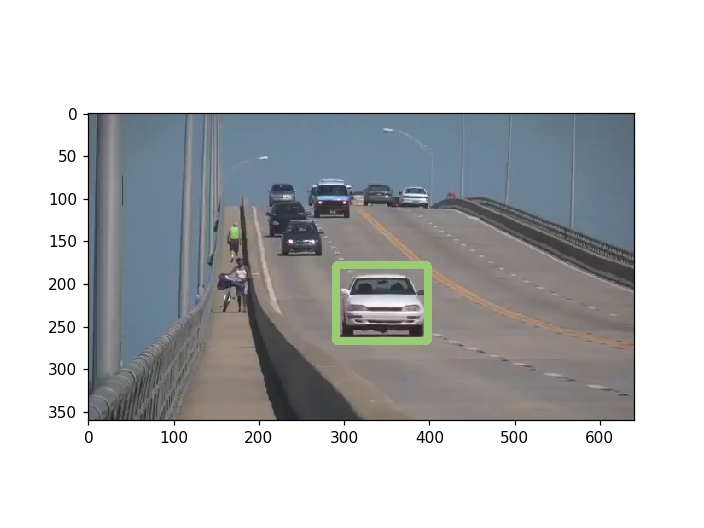

Button(description='Disconnect mpl', style=ButtonStyle())

In [9]:
cap = cv2.VideoCapture('./data/slow.mp4')
if(not cap.isOpened()):
    print('Error opening video')
ret,frame = cap.read()

frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
bs = bbox_select(frame)

ROI Points 확인

In [10]:
print(bs.selected_points)

[x1,y1],[x2,y2] = bs.selected_points

x1 = int(x1)
y1 = int(y1)
x2 = int(x2)
y2 = int(y2)

print(x1) # x[0]
print(y1) # y[0]
print(x2) # x[1]
print(y2) # y[1]

[[290.1781596522178, 178.53667389542443], [398.56525642641134, 267.5689319599405]]
290
178
398
267


#### Mean Shift
**Mean Shift라는 용어를 그대로 생각하면 평균(Mean)을 따라 이동(Shift)시킨다는 것 이다.**
또한 Mean Shift는 Histogram BackProjection을 통하여 Object Detection하는 Algorithm이다.  
어떻게 두개가 연관되어 수행되는지 알아보자.  

**Mean + Shift**  
먼저 MeanShift라는 용어의 관점에서 접근해보자.  
<img src="https://t1.daumcdn.net/cfile/tistory/2366BF4051930CE922"/><br>
사진 출처:<a href="https://darkpgmr.tistory.com/64">다크 프로그래머</a><br>
위의 사진과 같이 **Mean Shift는 어떤 데이터 분포의 peak 또는 무게중심을 찾는 한 방법으로서, 현재 자신의 주변에서 가장 데이터가 밀집된 방향으로 이동하다보면 언젠가는 분포 중심을 찾을 수 있을 거라는 방법이다.**  
위와 같은 방법은 **Deep Learning에서 Local Maxima나 Local Minima를 찾는 방법과 같다.**  
위와 같이 탐색적으로 차근차근 변하는 방식을 Greedy한 탐색방법이라 한다.  
하지만 이러한 Greedy 탐색 방법은 크게 3가지의 단점이 존재하게 된다.  
1. Local Minima
2. Plateau
3. Zigzag

위에 대한 단점에 관한 자세한 내용은 아래링크를 참조하자.  
**참조사항(Greedy 탐색 방법 단점)**: <a href="https://wjddyd66.github.io/dl/2019/07/26/NeuralNetwork-(3)-Optimazation2.html"></a>Optimazation 고려사항<br>


**Histogram BackProjection**  
Histogram BackProjection을 사용하게 되면 해당 Pixel의 값을 확률로서 표현할 수 있다.  

먼저 Histogram BackProjection만 사용하여 Object Detection을 한다고 생각해 보자.  
<img src="https://t1.daumcdn.net/cfile/tistory/223E723F519321B61F"/><br>
사진 출처:<a href="https://darkpgmr.tistory.com/64">다크 프로그래머</a><br>
위의 사진과 같이 **사용자가 지정한 ROI와 비슷한 Histogram 분포를 찾기 위하여 Input Image에 Sliding Window를 적용해 모든 값을 비교해야 하는 많은 연산을 필요하게 된다.**  

Histogram BackProjection과 Meah Shift를 사용한 기법은 아래와 같이 진행된다.  
<img src="https://t1.daumcdn.net/cfile/tistory/2222294F519325C001"/><br>
사진 출처:<a href="https://darkpgmr.tistory.com/64">다크 프로그래머</a><br>

- Histogram BackProjection을 통하여 Image의 pixel을 확률로서 표현할 수 있다.
- <span>$w(x) = \sqrt{\frac{H_{model}(I(x))}{H_{bkg}(I(x))}}$</span>의 의미를 살펴보면 Histogram Backprojection에 대한 Model Histogram의 값이다. 즉 Model과 비슷한 값을 가진 pixel은 큰 값을 가지고, 아닌값은 0을 가질 것이라 알 수 있다.
- <span>$\triangle x = \frac{\sum w(x)(x-\bar{x_{old}})K(x-\bar{x_{old}})}{\sum w(x)K(x-\bar{x_{old}})}$</span>의 의미를 살펴보게 되면 위에서 구한 가중치에 Image의 변환을 통하여 Mean Shift를 구할 수 있다. **2번째의 과정을 통하여 ROI영역 외의 Moving Object는 가중치가 0이므로 값은 변하지 않을 것 이다.** 즉, Moving Object 중 w(x)에 의하여 ROI로 지정한 Object에 대해서만 Tracking할 것임을 예상할 수 있다.
- <span>$\bar{x_{new}} = \bar{x_{old}} + \triangle x$</span>

#### cv2.meanShift(), cv2.camShift()
- hsv: Color Image를 hsv로 변환
- mask: 일정 값 이상의 ThreshHold값만 Image로서 사용, 어둡고, 흐릿한 영역을 제거하기 위하여
- mask_roi: 사용자가 지정한 ROI의 영역(Color)
- hsv_roi: 사용자가 지정한 ROI의 영역(HSV)
- track_window: <code>cv2.meanShift(), cv2.CamShift()</code>는 Window이동하면서 같은 물체를 Histogram Backporjection으로서 찾아내는 Algorithm이다 따라서 같은 크기의 Window로서 설정하였다.
- backP: Histogram Back Projection결과
- track_window1: MeanShift로서 찾아낸 Object의 Points
- track_window1: CamShift로서 찾아낸 Object의 Points
- ROI로 지정한 Object가 일정 시간동안 Detection되지 않으면 동영상 재생을 중지하였다.


In [11]:
height,width = (int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
roi_mask = np.zeros((height,width),dtype=np.uint8)
term_crit = (cv2.TERM_CRITERIA_MAX_ITER+cv2.TERM_CRITERIA_EPS,10,1)
t=0

hsv = cv2.cvtColor(frame,cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv,(0.,60.,32.),(180.,255.,255.))
  
mask_roi = mask[y1:y2,x1:x2]
hsv_roi = hsv[y1:y2,x1:x2]
        
hist_roi = cv2.calcHist([hsv_roi],[0],mask_roi,[16],[0,180])
cv2.normalize(hist_roi,hist_roi,0,255,cv2.NORM_MINMAX)

track_window1 = (x1,y1,x2-x1,y2-y1)
track_window2 = (x1,y1,x2-x1,y2-y1)

#cv2.rectangle(img,pt1,pt2,(np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255)),7)
        
        
wImg1 = widgets.Image(layout = widgets.Layout(border="solid"), width="30%") 
wImg2 = widgets.Image(layout = widgets.Layout(border="solid"), width="30%") 
wImg3 = widgets.Image(layout = widgets.Layout(border="solid"), width="30%") 

items = [wImg1, wImg2, wImg3]
box = Box(children=items)
display.display(box)

count = 0
while True:
    try:
        retval, frame = cap.read()
        if not retval:
            break
        t+=1
        
        hsv = cv2.cvtColor(frame,cv2.COLOR_RGB2HSV)
        backP = cv2.calcBackProject([hsv],[0],hist_roi,[0,180],1)
        #backP &= mask
        
        frame2 = frame.copy()
        wImg1.value = cv2.imencode(".jpeg", frame)[1].tostring()
        
        ret,track_window1 = cv2.meanShift(backP,track_window1,term_crit)
        x,y,w,h = track_window1
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),2)
        
        
        track_box,track_window2 = cv2.CamShift(backP,track_window2,term_crit)
        x,y,w,h = track_window2
        cv2.rectangle(frame2,(x,y),(x+w,y+h),(0,255,0),2)
        cv2.ellipse(frame2,track_box,(0,255,255),2)
            
        pts = cv2.boxPoints(track_box)
        pts = np.int32(pts)
        dst = cv2.polylines(frame2,[pts],True,(0,0,255),2)
        
        wImg2.value = cv2.imencode(".jpeg", frame)[1].tostring()
        wImg3.value = cv2.imencode(".jpeg", frame2)[1].tostring()
        
        
        if (x+w) >= width or (y+h)>=height:
            if count > 40:
                print('Object Deleting')
                break
            else:
                count += 1
                
        
    except KeyboardInterrupt:
        break
        
if cap.isOpened():
    cap.release()

Box(children=(Image(value=b'', layout="Layout(border='solid')", width='30%'), Image(value=b'', layout="Layout(…

Object Deleting


### Kalman Filter
Kalman Filter란 부정확한 측정값으로부터 오차를 최소화 하는 추정치를 반복적으로 계산하는 방법이다.  
Kalman Filter는 다음과 같은 두가지의 경우에 잘 사용할 수 있다.  
1. 모션 모델과 측정 모델이 Linear할 경우
2. 모션 모델과 측정 모델이 Gaussian 분포를 따를 경우

위의 두가지 경우가 아닌 경우에는 확장 칼만 필터로서 구현하여 Object의 Detection을 해야 한다.  

Kalman Filter의 프로세스 방적식과 측정 방정식은 다음과 같다.  
<img src="https://t1.daumcdn.net/cfile/tistory/2167763755215C8408"/>
<img src="https://t1.daumcdn.net/cfile/tistory/267FFE3355215CF021"/>
<br>
사진 출처: <a href="https://vision0814.tistory.com/163">vision0814 블로그</a><br>

간단하게 정의하자면 **현재 시간(k)의 값(<span>$x_k$</span>)이 현재 시간(k)에 얼만큼 영향을 미칠건지에 대한 Weight를 B를 곱한 값과 이전 시간(k-1)의 값(<span>$x_{k-1}$</span>)이 현재 시간(k)에 얼만큼 영향을 미칠건지에 대한 Weight를 A를 곱한 값 으로서 weight A,B를 계속해서 Update해나가는 과정이다.**  

Kalman Filter에 대한 내용은 이번 Post에서 해결하기 어려울 정도로 많습니다.  
자세한 내용은 아래 링크를 참조하자.  
<a href="https://medium.com/@celinachild/kalman-filter-%EC%86%8C%EA%B0%9C-395c2016b4d6">Kalman Filter 자세한 내용</a>


**cv2.KalmanFilter 클래스 속성**  
<table class="table">
	<tr>
		<td>KalmanFilter 속성</td>
		<td>설명</td>
        <td>비고</td>
	</tr>
    <tr>
		<td>statePre</td>
		<td>예측상태(prediction state)</td>
        <td><span>$x_k^{'}$</span></td>
	</tr>
    <tr>
		<td>statePost</td>
		<td>정정상태(corrected state)</td>
        <td><span>$x_k$</span></td>
	</tr>
    <tr>
		<td>transitionMatrix</td>
		<td>상태 변환행렬(state transition matrix)</td>
        <td><span>$A$</span></td>
	</tr>
    <tr>
		<td>controlMatrix</td>
		<td>제어 행렬(control matrix)</td>
        <td><span>$B$</span></td>
	</tr>
    <tr>
		<td>measurementMatrix</td>
		<td>측정 행렬(measurement matrix)</td>
        <td><span>$H$</span></td>
	</tr>
    <tr>
		<td>processNoiseCov</td>
		<td>프로세스 잡음 공분산(control process noise covariance matrix)</td>
        <td><span>$Q$</span></td>
	</tr>
    <tr>
		<td>measurementNoiseVoc</td>
		<td>측정 잡음 공분산(measurement noise covariance matrix)</td>
        <td><span>$Q$</span></td>
	</tr>
    <tr>
		<td>errorCovPre</td>
		<td>사전 오차 추정 공분산 행렬(priori error estimate covariance matrix)</td>
        <td><span>$P_k^{'}$</span></td>
	</tr>
    <tr>
		<td>gain</td>
		<td>칼만 이득(Kalman gain matrix)</td>
        <td><span>$K_k$</span></td>
	</tr>
    <tr>
		<td>errorCovPost</td>
		<td>사후 오차 추정 공분산 행렬(posteriori error estimate covariance matrix)</td>
        <td><span>$P_k$</span></td>
	</tr>
	

</table>
<br>

<code>cv2.KalmanFilter([dynamParams, measureParams[, controlParams[, type]]])</code>: KalmanFilter 객체 생성<br>

**parameter**
- dynamParams: 상태 벡터(state vector)의 차원(dimensionality)
- measureParams: 측정 벡터(measurement vector)의 차원
- controlParams: 외부 제어 벡터(control vector)의 차원
- type: 생성되는 행렬의 자료형

<br>

<code>cv2.KalmanFilter.predict([control])</code>: 예측 상태(predicted state), statePre를 계산, <span>$x_k^{'}$</span>반환<br>

**parameter**
- control: 외부 컨트롤 <span>$u_k$</span>

<br>

<code>cv2.KalmanFilter.correct(measurement)</code>: Measurement를 사용하여 상태를 정정, <span>$x_k$</span>반환<br>

#### cv2.KalmanFilter 랜덤 상수 추정
- x: 실제값
- z: Noise + x
- P: 실제값과 예측값의 차이
- X: 예측값


<IPython.core.display.Javascript object>


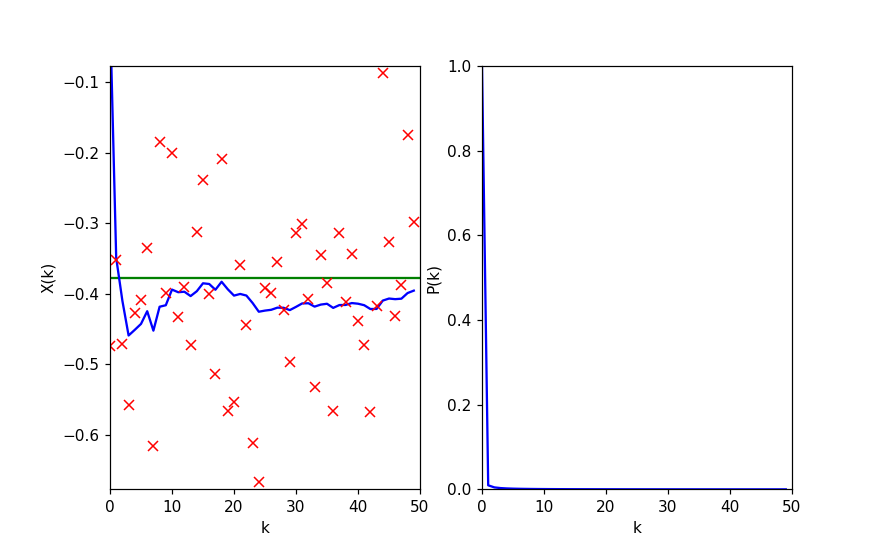

In [13]:
x = -0.37727

q = 1e-5
r = 0.01

KF = cv2.KalmanFilter(1,1,0) #B=0
KF.transitionMatrix = np.ones((1,1)) #A=1
KF.measurementMatrix=np.ones((1,1)) #H=1
KF.processNoiseCov = q * np.eye(1) #Q
KF.measurementNoiseCov = r*np.eye(1) #R

KF.errorCovPost = np.ones((1,1))
KF.statePost = np.zeros((1,1))

N=50
z = np.random.randn(N,1)*np.sqrt(r)+x #measurement
X = [KF.statePost[0,0]] #initial value
P = [KF.errorCovPost[0,0]] #initial errorCovPost

for k in range(1,N):
    predict = KF.predict()
    estimate = KF.correct(z[k])
    X.append(estimate[0,0])
    P.append(KF.errorCovPost[0,0])

plt.figure(figsize=(8,5))
imgae1=plt.subplot(1,2,1)
plt.xlabel('k')
plt.ylabel('X(k)')
plt.axis([0,N,x-3*np.sqrt(r),x+3*np.sqrt(r)])
plt.plot([0,N],[x,x],'g-')
plt.plot(X,'b-')
plt.plot(z,'rx')

imgae2=plt.subplot(1,2,2)
plt.xlabel('k')
plt.ylabel('P(k)')
plt.axis([0,N,0,1.0])
plt.plot([0,N],[x,x],'g-')
plt.plot(P,'b-')

plt.show()

#### cv2.KalmanFilter 랜덤상수 추정2
위와 같은 과정이나, Animation을 추가하여 지속적으로 계속 관찰한다.

<IPython.core.display.Javascript object>


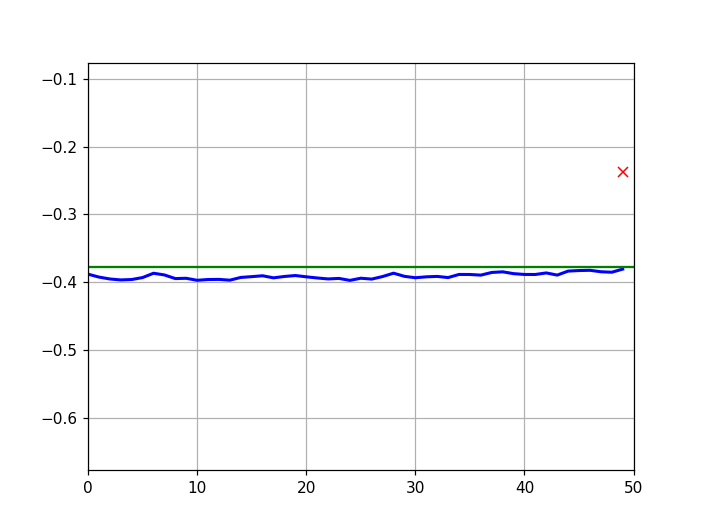

In [14]:
x = -0.37727

q = 1e-5
r = 0.01

KF = cv2.KalmanFilter(1,1,0)
KF.transitionMatrix = np.ones((1,1))
KF.measurementMatrix=np.ones((1,1))
KF.processNoiseCov = q * np.eye(1)
KF.measurementNoiseCov = r*np.eye(1)

KF.errorCovPost = np.ones((1,1))
KF.statePost = np.zeros((1,1))

N=50
z = np.random.randn(N,1)*np.sqrt(r)+x
X = [KF.statePost[0,0]]
P = [KF.errorCovPost[0,0]]

fig = plt.figure()
fig.canvas.set_window_title('Kalman Filter')
ax = plt.axes(xlim=(0,N),ylim=(x-3*np.sqrt(r),x+3*np.sqrt(r)))
ax.grid()
line1, = ax.plot([],[],'b-',lw=2)
line2, = ax.plot([],[],'rx')
line3, = ax.plot([0,N],[x,x],'g-')
xrange=np.arange(N)
Z=[]

def init():
    for k in range(N):
        predict = KF.predict()
        z = np.random.randn(1,1)*np.sqrt(r)+x
        estimate = KF.correct(z[0])
        X.append(estimate[0,0])
        Z.append(z[0][0])
    line1.set_data(xrange,X)
    line2.set_data(xrange,Z)
    return line1,line2

def animate(k):
    global X,Z
    predict = KF.predict()
    z = np.random.randn(1,1)*np.sqrt(r)+x
    estimate = KF.correct(z[0])
    
    X = X[1:N]
    X.append(estimate[0,0])
    Z = Z[1:N]
    Z.append(z[0][0])
    line1.set_data(xrange,X)
    line2.set_data([N-1],z)
    
ani = animation.FuncAnimation(fig,animate,init_func=init,interval=25,blit=True)

plt.show()

#### cv2.meanShift + cv2.KalmanFilter 물체 추적
- 빨간원: MeanShift
- 파란색 박스: KalmanFilter

<IPython.core.display.Javascript object>


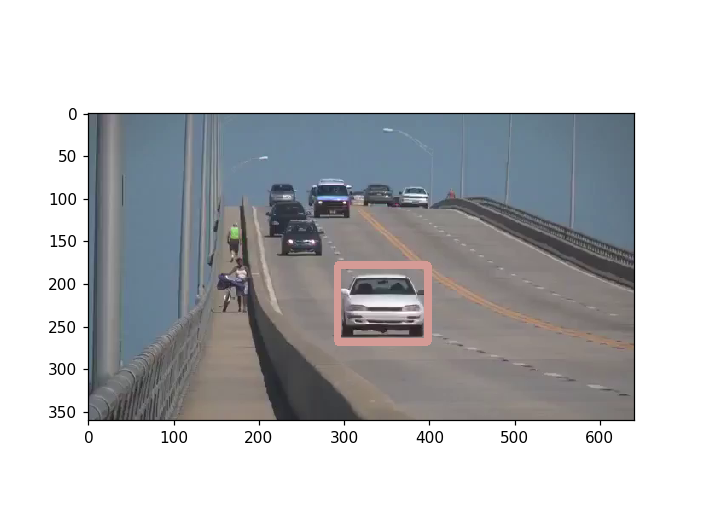

Button(description='Disconnect mpl', style=ButtonStyle())

In [56]:
cap = cv2.VideoCapture('./data/Slow.mp4')
if(not cap.isOpened()):
    print('Error opening video')
ret,frame = cap.read()

frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
bs = bbox_select(frame)

if cap.isOpened():
    cap.release()

In [57]:
[x1,y1],[x2,y2] = bs.selected_points

x1 = int(x1)
y1 = int(y1)
x2 = int(x2)
y2 = int(y2)
print(x1,y1,x2,y2)

292 178 398 268


In [58]:
cap = cv2.VideoCapture('./data/Slow.mp4')

height,width = (int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
roi_mask = np.zeros((height,width),dtype=np.uint8)
term_crit = (cv2.TERM_CRITERIA_MAX_ITER+cv2.TERM_CRITERIA_EPS,10,1)
t=0

hsv = cv2.cvtColor(frame,cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv,(0.,60.,32.),(180.,255.,255.))
        
mask_roi = mask[y1:y2,x1:x2]
hsv_roi = hsv[y1:y2,x1:x2]
        
hist_roi = cv2.calcHist([hsv_roi],[0],mask_roi,[16],[0,180])
cv2.normalize(hist_roi,hist_roi,0,255,cv2.NORM_MINMAX)
H1=hist_roi.copy()
cv2.normalize(H1,H1,0.0,1.0,cv2.NORM_MINMAX)
        
track_window = (x1,y1,x2-x1,y2-y1)

wImg = widgets.Image(layout = widgets.Layout(border="solid"), width="30%") 
display.display(wImg)

# Kalman Filter Setup
q = 1e-5
r=0.01
dt=1
KF=cv2.KalmanFilter(4,2,0)
KF.transitionMatrix = np.array([[1,0,dt,0],
                               [0,1,0,dt],
                               [0,0,1,0],
                               [0,0,0,1]],np.float32)
KF.measurementMatrix = np.array([[1,0,0,0],
                                [0,1,0,0]],np.float32)

count = 0
while True:
    try:
        retval, frame = cap.read()
        if not retval:
            break
        t+=1
        frame2 = frame.copy()
        hsv = cv2.cvtColor(frame,cv2.COLOR_RGB2HSV)
        
        #Kalman filter initialize
        KF.processNoiseCov = q*np.eye(4,dtype=np.float32)
        KF.measurementNoiseCov = r*np.eye(2,dtype=np.float32)
        KF.errorCovPost = np.eye(4,dtype=np.float32)
        
        x,y,w,h = track_window
        KF.statePost = np.array([[x],[y],[0.],[0.]],dtype=np.float32)
        
        predict = KF.predict()            
        backP = cv2.calcBackProject([hsv],[0],hist_roi,[0,180],1)
        backP &= mask
        
        ret,track_window = cv2.meanShift(backP,track_window,term_crit)
        x,y,w,h = track_window
        cv2.circle(frame,(int(x+w/2),int(y+h/2)),5,(0,0,255),10)
            
        z = np.array([[x],[y]],dtype=np.float32)
        estimate = KF.correct(z)
        estimate = np.int32(estimate)
            
        x2,y2 = estimate[0][0],estimate[1][0]
        
        cv2.rectangle(frame,(x2,y2),(x2+w,y2+h),(255,0,0),10)
        
        wImg.value = cv2.imencode(".jpeg", frame)[1].tostring()
        
        
        if (x2+w) >= width or (y2+h)>=height:
            if count > 40:
                print('Object Deleting')
                break
            else:
                count += 1
                
    except KeyboardInterrupt:
        break
        
if cap.isOpened():
    cap.release()

Image(value=b'', layout="Layout(border='solid')", width='30%')

Object Deleting
